<a href="https://colab.research.google.com/github/Daisy-M-RGB/covidprojectCollege/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
#pip install pmdarima

     |████████████████████████████████| 1.5MB 8.0MB/s 


In [ ]:
# importing the required libraries
import pandas as pd
import numpy as np
# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 8, 10
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
confirmed_cases = pd.read_csv('/content/drive/MyDrive/dataset/time_series_covid19_confirmed_global.csv')

In [ ]:
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,59370,59576,59745,59939,60122,60300,60563,60797,61162,61455,61755,61842,62063,62403,62718,63045,63355,63412,63484,63598,63819,64122,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111,70761,71838,72977,74026,75119,76628,77963,79224
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,130859,130977,131085,131185,131238,131276,131327,131419,131510,131577,131666,131723,131753,131803,131845,131890,131939,131978,132015,132032,132071,132095,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297,132309,132315,132337,132351,132360,132372,132374,132379
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,121580,121866,122108,122311,122522,122717,122999,123272,123473,123692,123900,124104,124288,124483,124682,124889,125059,125194,125311,125485,125693,125896,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456,128725,128913,129218,129640,129976,130361,130681,130958
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13148,13198,13232,13232,13282,13295,13316,13340,13363,13390,13406,13423,13429,13447,13470,13470,13510,13510,13510,13555,13569,13569,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693,13693,13727,13729,13744,13752,13758,13758,13758
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,26168,26431,26652,26815,26993,27133,27284,27529,27921,28201,28477,28740,28875,29146,29405,29695,30030,30354,30637,30787,31045,31438,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180,34366,34551,34752,34960,35140,35307,35594,35772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,2865,2910,2928,2942,2962,2985,2995,3030,3090,3137,3245,3412,3489,3571,3658,3740,3816,4112,4212,4359,4512,4720,4809,4941,5119,5275,5404,5931,6086,6356,6396,6908,7107,7432,7625,7870,8063,8364,8580,8791
272,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,294550,295601,296462,296462,297638,298203,298921,299736,300387,300946,301437,301751,302249,302777,303270,303270,303270,303658,303827,304074,304074,304532,304532,304968,305201,305201,305777,306334,306795,306795,307569,307838,308048,308350,308732,309036,309333,309644,309853,310026
273,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6263,6294,6317,6325,6341,6363,6390,6414,6426,6446,6462,6482,6485,6492,6498,6507,6523,6538,6543,6568,6586,6593,6613,6632,6649,6658,6662,6670,6688,6696,6723,6731,6737,6742,6751,6759,6767,6773,6780,6787
274,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91484,91533,91586,91670,91693,91722,91804,91849,91946

### merging dataframes

In [ ]:
# extract dates
dates = confirmed_cases.columns[4:]

confirmed_df = confirmed_cases.melt(id_vars=['Province/State', 'Country/Region','Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')


print(confirmed_df.shape)

(138552, 6)


In [ ]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


In [ ]:
confirmed_df.isnull().sum()

Province/State    95380
Country/Region        0
Lat                1004
Long               1004
Date                  0
Confirmed             0
dtype: int64

In [ ]:
confirmed_df.drop(['Lat', 'Long'],axis=1,inplace=True)

In [ ]:
confirmed_df['Date'] = pd.to_datetime(confirmed_df['Date'])

In [ ]:
confirmed = confirmed_df.groupby('Date').sum()['Confirmed'].reset_index()

In [ ]:
confirmed

,Date,Confirmed
0,2020-01-22,557
1,2020-01-23,655
2,2020-01-24,941
3,2020-01-25,1433
4,2020-01-26,2118
...,...,...
497,2021-06-02,171680812
498,2021-06-03,172169929
499,2021-06-04,172589646
500,2021-06-05,172987591


In [ ]:
confirmed.set_index('Date',inplace=True)

In [ ]:
confirmed

,Confirmed
Date,
2020-01-22,557
2020-01-23,655
2020-01-24,941
2020-01-25,1433
2020-01-26,2118
...,...
2021-06-02,171680812
2021-06-03,172169929
2021-06-04,172589646


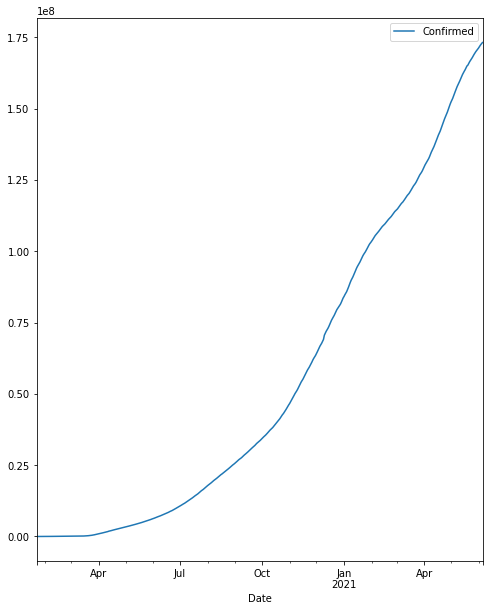

In [ ]:
confirmed.plot()

In [ ]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(confirmed['Confirmed'])

In [ ]:
def adfuller_test(Confirmed):
    result=adfuller(Confirmed)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(confirmed['Confirmed'])

ADF Test Statistic : 0.02026333776247091
p-value : 0.9601761117089871
#Lags Used : 15
Number of Observations Used : 486
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
# Calculate the log 
confirmed['adj_log'] = np.log(confirmed['Confirmed'])

In [ ]:
confirmed['confirmed_log_diff'] = confirmed['adj_log']  - confirmed['adj_log'] .shift(1)

In [ ]:
adfuller_test(confirmed['confirmed_log_diff'].dropna())

ADF Test Statistic : -2.98675454427855
p-value : 0.036150010944704936
#Lags Used : 17
Number of Observations Used : 483
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
from pmdarima import auto_arima

In [ ]:
stepwise_fit = auto_arima(confirmed['Confirmed'],trace= True, suppress_warnings= True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=12466.386, Time=0.92 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12675.502, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=12661.549, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=12645.546, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=12590.546, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=12579.015, Time=0.24 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=12411.232, Time=1.09 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=12531.768, Time=0.26 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=12383.181, Time=1.27 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=12485.929, Time=0.28 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=12374.785, Time=1.74 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=12449.639, Time=0.51 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=12383.437, Time=2.10 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=12410.423, Time=1.68 sec
 ARIMA(5,2,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  502
Model:               SARIMAX(5, 2, 2)   Log Likelihood               -6179.393
Date:                Wed, 23 Jun 2021   AIC                          12374.785
Time:                        16:16:36   BIC                          12408.502
Sample:                             0   HQIC                         12388.016
                                - 502                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5329      0.046     11.692      0.000       0.444       0.622
ar.L2         -0.5319      0.031    -17.232      0.000      -0.592      -0.471
ar.L3         -0.3581      0.029    -12.498      0.000      -0.414      -0.302
ar.L4         -0.1984      0.032     -6.245      0.000      -0.261      -0.136
ar.L5         -0.1719      0.050     -3.445      0.001      -0.270      -0.074
ma.L1         -1.1851      0.040    -29.356      0.000      -1.264      -1.106
ma.L2          0.8616      0.027     32.408      0.000       0.809       0.914
sigma2       3.61e+09   2.76e-11   1.31e+20      0.000    3.61e+09    3.61e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            169023.62
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              44.01   Skew:                             4.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        92.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+36. Standard errors may be unstable.
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

split data into train and test set

In [ ]:
print(confirmed.shape)

(502, 6)


In [ ]:
train = confirmed.iloc[:-30]
test = confirmed.iloc[-30:]

In [ ]:
print(train.shape,test.shape)

(472, 6) (30, 6)


train the model

In [ ]:
model = ARIMA(train['Confirmed'],order=(5,2,2))
model = model.fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.Confirmed   No. Observations:                  470
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -5774.404
Method:                       css-mle   S.D. of innovations          52173.039
Date:                Wed, 23 Jun 2021   AIC                          11566.808
Time:                        16:31:14   BIC                          11604.183
Sample:                    01-24-2020   HQIC                         11581.512
                         - 05-07-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1770.8672    951.212      1.862      0.063     -93.474    3635.208
ar.L1.D2.Confirmed     0.5371      0.061      8.736      0.000       0.417       0.658
ar.L2.D2.Confirmed    -0.5079      0.053     -9.644      0.000      -0.611      -0.405
ar.L3.D2.Confirmed    -0.3794      0.053     -7.097      0.000      -0.484      -0.275
ar.L4.D2.Confirmed    -0.1853      0.054     -3.419      0.001      -0.291      -0.079
ar.L5.D2.Confirmed    -0.1608      0.051     -3.135      0.002      -0.261      -0.060
ma.L1.D2.Confirmed    -1.1943      0.041    -29.002      0.000      -1.275      -1.114
ma.L2.D2.Confirmed     0.8631      0.041     20.866      0.000       0.782       0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6246           -0.7849j            1.0031           -0.1430
AR.2            0.6246           +0.7849j            1.0031            0.1430
AR.3           -1.8526           -0.0000j            1.8526           -0.5000
AR.4           -0.2746           -1.8060j            1.8267           -0.2740
AR.5           -0.2746           +1.8060j            1.8267            0.2740
MA.1            0.6918           -0.8246j            1.0764           -0.1389
MA.2            0.6918           +0.8246j            1.0764            0.1389
-----------------------------------------------------------------------------
"""

make predictions on test set

In [ ]:
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start,end=end,typ='levels')
print(pred)

2021-05-08    1.576595e+08
2021-05-09    1.583474e+08
2021-05-10    1.590476e+08
2021-05-11    1.598229e+08
2021-05-12    1.606807e+08
2021-05-13    1.615678e+08
2021-05-14    1.624113e+08
2021-05-15    1.631724e+08
2021-05-16    1.638759e+08
2021-05-17    1.645911e+08
2021-05-18    1.653795e+08
2021-05-19    1.662485e+08
2021-05-20    1.671460e+08
2021-05-21    1.680002e+08
2021-05-22    1.687737e+08
2021-05-23    1.694913e+08
2021-05-24    1.702210e+08
2021-05-25    1.710228e+08
2021-05-26    1.719031e+08
2021-05-27    1.728109e+08
2021-05-28    1.736758e+08
2021-05-29    1.744618e+08
2021-05-30    1.751935e+08
2021-05-31    1.759377e+08
2021-06-01    1.767527e+08
2021-06-02    1.776445e+08
2021-06-03    1.785626e+08
2021-06-04    1.794383e+08
2021-06-05    1.802367e+08
2021-06-06    1.809825e+08
Freq: D, dtype: float64


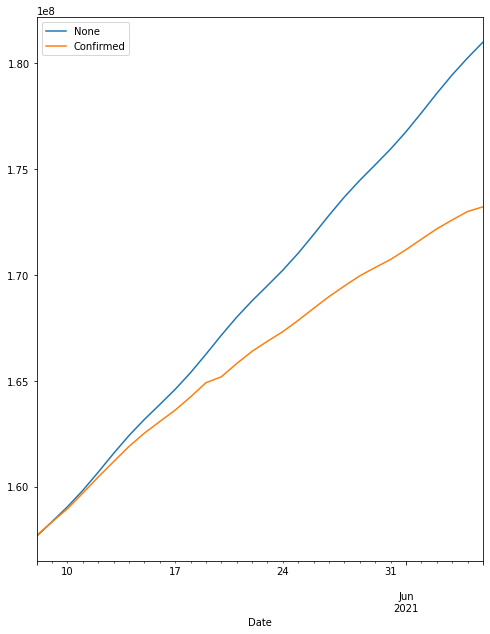

In [ ]:
pred.plot(legend=True)
test['Confirmed'].plot(legend=True)

In [ ]:
test['Confirmed'].mean()

166256864.33333334

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test['Confirmed']))
print(rmse)

3777493.0979347066


we can see above that mean of the test set is 166256864.33333334 whereas rmse is 3777493.0979347066 , error in compare to mean is acceptable.

now making future predictions

In [ ]:
model2 = ARIMA(confirmed['Confirmed'],order=(5,2,2))
model2 = model2.fit()
confirmed.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,Confirmed,confirmed First Difference,adj_log,adj_sqrt,adj_cbrt,confirmed_log_diff
Date,,,,,,
2021-06-02,171680812,18124876.0,18.961148,13102.702469,555.785552,0.002877
2021-06-03,172169929,17806574.0,18.963993,13121.353932,556.312861,0.002845
2021-06-04,172589646,17385089.0,18.966427,13137.337858,556.764555,0.002435
2021-06-05,172987591,16913024.0,18.968730,13152.474710,557.192143,0.002303
2021-06-06,173209947,16302974.0,18.970015,13160.925005,557.430776,0.001285


In [ ]:
index_future_dates = pd.date_range(start='2021-06-06',end='2021-07-06')
print(index_future_dates)

DatetimeIndex(['2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09',
               '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13',
               '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21',
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29',
               '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03',
               '2021-07-04', '2021-07-05', '2021-07-06'],
              dtype='datetime64[ns]', freq='D')


In [ ]:
pred = model2.predict(start=len(confirmed),end=len(confirmed)+30,typ='levels').rename('ARIMA predictions')
print(pred)

2021-06-07    1.735379e+08
2021-06-08    1.739063e+08
2021-06-09    1.743199e+08
2021-06-10    1.747376e+08
2021-06-11    1.751290e+08
2021-06-12    1.754626e+08
2021-06-13    1.757629e+08
2021-06-14    1.760777e+08
2021-06-15    1.764439e+08
2021-06-16    1.768584e+08
2021-06-17    1.772835e+08
2021-06-18    1.776737e+08
2021-06-19    1.780105e+08
2021-06-20    1.783161e+08
2021-06-21    1.786361e+08
2021-06-22    1.790055e+08
2021-06-23    1.794220e+08
2021-06-24    1.798483e+08
2021-06-25    1.802404e+08
2021-06-26    1.805807e+08
2021-06-27    1.808911e+08
2021-06-28    1.812160e+08
2021-06-29    1.815890e+08
2021-06-30    1.820074e+08
2021-07-01    1.824350e+08
2021-07-02    1.828290e+08
2021-07-03    1.831728e+08
2021-07-04    1.834880e+08
2021-07-05    1.838177e+08
2021-07-06    1.841942e+08
2021-07-07    1.846146e+08
Freq: D, Name: ARIMA predictions, dtype: float64
